[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khouakhi/ewin_mex/blob/master/%20Data_%20prep_%20level.ipynb)



> Running this notebook requires generating some data from a previous notebook found here [Data prep1](https://colab.research.google.com/github/khouakhi/ewin_mex/blob/master/RC_data_prep1.ipynb) 










Run the first two cells if you open this notebook in Colab


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%cd './drive/My Drive'
%pwd

In [0]:
import pandas as pd
import os
import matplotlib.pyplot as plt

#### Data source path 

In [0]:
data_source = './ewin_mex/data'
file_names = os.listdir(data_source)

###Hourly level data 

In [0]:
hourly_level = os.path.join(data_source,"hourly_level")
lvl_file_names = os.listdir(hourly_level)
lvl_file_names

['rc_Node5.csv',
 'rc_Node6.csv',
 'rc_Node10.csv',
 'rc_Node13.csv',
 'rc_Node3.csv',
 'rc_Node14.csv']

###Examine node 3 data 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe4b1713fd0>,
      dtype=object)

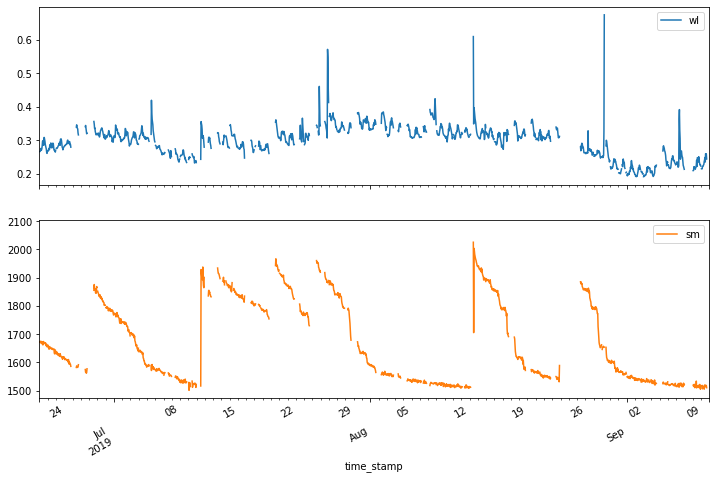

In [0]:
# read node 3 data
node3_path = os.path.join(hourly_level,'rc_Node3.csv')
node3 = pd.read_csv(node3_path,infer_datetime_format= True,
                  parse_dates=True,index_col='time_stamp')
node3 = node3.sort_values(by=['time_stamp'])
node3 = node3.resample('h').mean()
# check for null values 
node3.isnull().sum()
# plot good data 
node3.loc['2019-06-22':'2019-09-10'].plot(subplots=True, figsize=(12, 8))


In [0]:
# omit bad data and keep June to sept 
node3_junSep = node3.loc['2019-06-22':'2019-09-10']
# impute missing data
node3_junSep['interp'] = node3_junSep['wl'].interpolate(method='linear')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


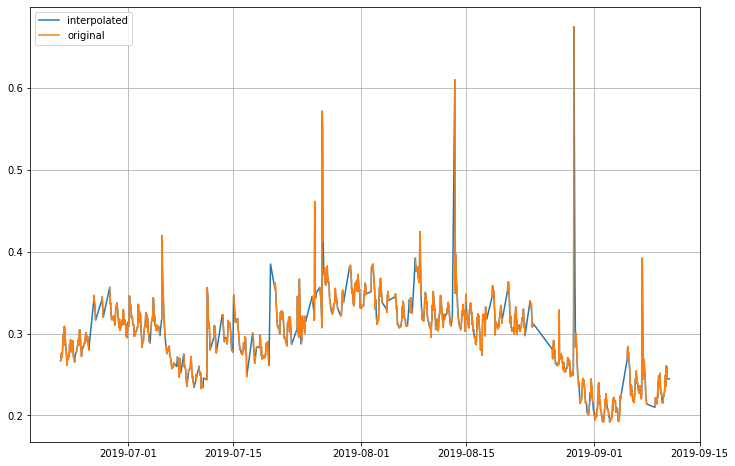

In [0]:
# plot imputed data
plt.figure(figsize=(12,8))
plt.grid(True)
plt.plot(node3_junSep['interp'], label = "interpolated")
plt.plot(node3_junSep['wl'], label = "original")
plt.legend(loc=2)
plt.show()

###Interpolate both wl and sm and change the columns name to wl target and sm target 

In [0]:
# interpolate both wl and sm
node3_junSep = node3.loc['2019-06-22':'2019-09-10']
node3_junSep_final = node3_junSep.interpolate(method='linear')#'akima'
node3_junSep_final.columns = ['wl_target', 'sm_target']

####Append Atmos data to the level data 

In [0]:
hourly_atmos = os.path.join(data_source,"hourly_atmos")
prcp_file_names = os.listdir(hourly_atmos)

In [0]:
# put all the atmos data together
appended_atmos = []
for i in prcp_file_names:
  this_file = os.path.join(hourly_atmos,i)
  df = pd.read_csv(this_file,infer_datetime_format= True,
                   parse_dates=True,index_col='time_stamp') 
  # sort by datetime
  df = df.sort_values(by=['time_stamp'])
  df = df.resample('h').mean()
  df.columns = df.columns + "_" + i[0:6]
  # store DataFrame in list
  appended_atmos.append(df)
# concat the appended 
appended_atmos = pd.concat(appended_atmos,axis = 1)
# keep data from '2019-06-22':'2019-09-10'
appended_atmos = appended_atmos.loc['2019-06-22':'2019-09-10']
#atmos_interp = appended_atmos.interpolate(method='nearest', limit_direction= 'both')#'akima'

appended_atmos.columns

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe4ae0db278>,
      dtype=object)

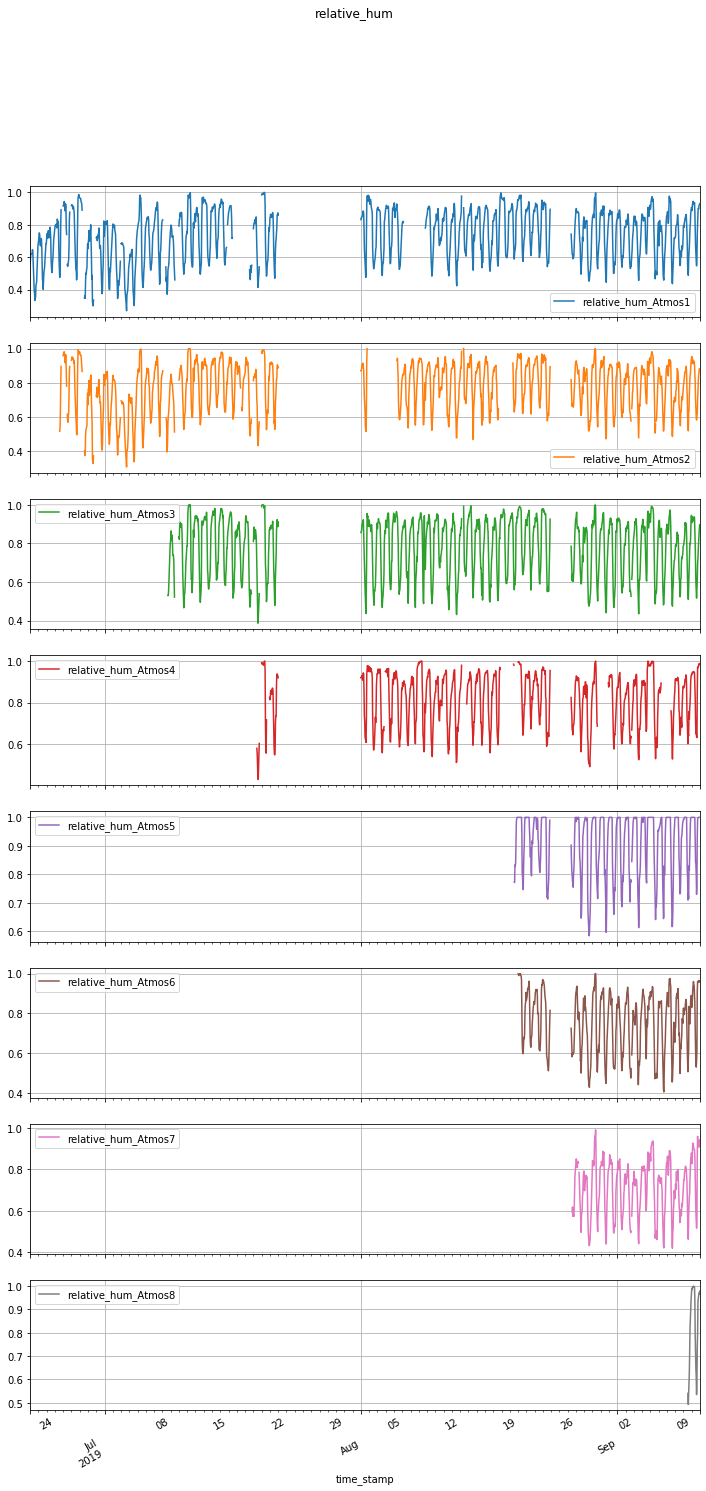

In [0]:
# plot prcp 
prcp_vars = [col for col in appended_atmos.columns if 'relative_hum' in col]
appended_atmos[prcp_vars].plot(subplots=True,
                  figsize=(12, 25),title='relative_hum', grid=True)

In [0]:
# select data from only Atmos1,2 and 3
atmos1 = [col for col in appended_atmos.columns if 'Atmos1' in col]
atmos2 = [col for col in appended_atmos.columns if 'Atmos2' in col]
atmos3 = [col for col in appended_atmos.columns if 'Atmos3' in col]
selected_cols = atmos1+atmos2+atmos3
#
appended_atmos2 = appended_atmos[selected_cols] 

In [0]:
# add level data 
ewin_net = pd.concat([appended_atmos2,node3_junSep_final], axis = 1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe4ad8c7940>,
      dtype=object)

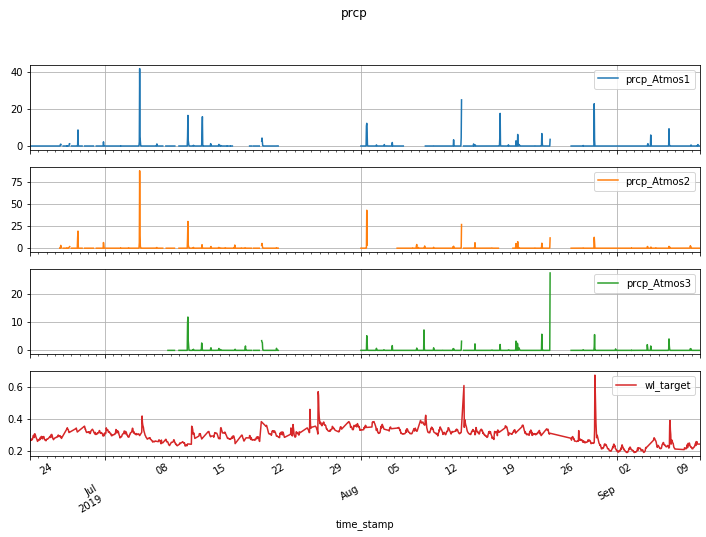

In [0]:
# plot prcp 
prcp_vars = [col for col in ewin_net.columns if 'prcp' in col]+['wl_target']
ewin_net[prcp_vars].plot(subplots=True,
                  figsize=(12, 8),title='prcp', grid=True)

In [0]:
# write DataFrame 
ewin_net.to_csv(data_source+'/rc_data.csv')